In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyarrow.feather as feather
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller, coint
from scipy.optimize import minimize
from datetime import datetime, timedelta
from IPython.core.interactiveshell import InteractiveShell
from matplotlib.ticker import ScalarFormatter

InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
mpl.rcParams['font.size'] = 16  # 기본 폰트 크기 설정
mpl.rcParams['axes.titlesize'] = 20  # 제목 폰트 크기 설정
mpl.rcParams['axes.labelsize'] = 18  # 축 레이블 폰트 크기 설정
mpl.rcParams['xtick.labelsize'] = 14  # x축 눈금 폰트 크기 설정
mpl.rcParams['ytick.labelsize'] = 14  # y축 눈금 폰트 크기 설정
mpl.rcParams['legend.fontsize'] = 16  # 범례 폰트 크기 설정

In [3]:
# price_df = feather.read_feather('data\\91_coin_price.feather')
# volume_df = feather.read_feather('data\\91_coin_volume.feather')
price_df = feather.read_feather('total_price_data.feather')
volume_df = feather.read_feather('total_volume_data.feather')

In [4]:
n_cols = [i[4:] for i in price_df.columns]
price_df.columns = n_cols
volume_df.columns = n_cols
agg_dict = {col:'last' for col in price_df.columns}

In [6]:
price_df = price_df.resample('1D').agg(agg_dict)

In [7]:
def get_formation_trading_df(price_df, formation_start_datetime, gap=False):
    formation_start = formation_start_datetime
    formation_end = formation_start + pd.DateOffset(months=12) - pd.Timedelta(days=1)
    trading_start = (formation_end + pd.Timedelta(days=1) if gap == False 
                                     else formation_end + pd.Timedelta(days=2))
    trading_end = trading_start + pd.DateOffset(months=6) - pd.Timedelta(days=1)
    log_price_df = np.log(price_df)
    tdf = log_price_df[formation_start:trading_end]
    tdf = tdf.dropna(axis=1)
    formation_df = tdf[formation_start:formation_end]
    trading_df = tdf[trading_start:trading_end]
    return formation_df, trading_df

In [68]:
top_n = 10

rolling_num = 0

total_return = np.zeros(60) # rolling 평균 성과
total_std = np.zeros(60)

cnt = 0

formation_start = price_df.index[0]
last_datetime = price_df.index[-1]

while 1:
    cnt += 1
    formation_end = formation_start +pd.DateOffset(months=12) - pd.Timedelta(days=1)
    trading_start = formation_end + pd.Timedelta(days=1)
    trading_end = trading_start + pd.DateOffset(months=6) - pd.Timedelta(days=1)
    
    if trading_end > last_datetime:
        break
    
    formation_df, trading_df = get_formation_trading_df(price_df, formation_start)
    print(f'#{cnt}:\t {formation_start} ~ {formation_end}\t{trading_start} ~ {trading_end}')
    
    top_df = pd.read_csv(f"data2/corr_{cnt}.csv")
    pair_names = top_df.loc[:top_n-1:][['coin1', 'coin2']]
    pair_names = pair_names.values

    # rolling_total_open = 0

    pair_index = 0
    rolling_pair_return = np.zeros(top_n)
    for c1, c2 in pair_names:
        pair_ret = 0
        
        first_asset_name = c1
        second_asset_name = c2
        in_X = formation_df[first_asset_name]
        in_Y = formation_df[second_asset_name]
        out_X = trading_df[first_asset_name]
        out_Y = trading_df[second_asset_name]

        in_model = sm.OLS(in_X, in_Y).fit()
        beta = in_model.params[0]
        in_coint_price = in_X - (beta * in_Y)
        out_coint_price = out_X - (beta * out_Y)

        insample_sd = np.std(in_coint_price)
        index = np.where(
            np.abs(out_coint_price) > (2*insample_sd)
        )[0]

        if len(index) != 0:
            # pair_open += 1
            
            pair_ind = out_coint_price[index[0]] < 0

            ind1 = int(pair_ind) - int(not pair_ind) # 주식 1의 경우 pair_ind가 음수면 롱, 양수면 숏
            ind2 = int(not pair_ind) - int(pair_ind) # 주식 2의 경우 pair_ind가 양수면 롱, 음수면 숏
            
            W = np.array([
                ind1 * (1 / out_X[index[0]]),
                ind2 * (1 / out_Y[index[0]])
            ])
            
            pair_port = np.dot(W, np.vstack([
                out_X[index[0]:],
                out_Y[index[0]:]
            ]))
            ind_sell = np.where(
                out_coint_price[index[0]:] * out_coint_price[index[0]] <= 0
            )[0]

            if len(ind_sell) == 0:
                pair_ret = pair_port[-1]
            else:
                pair_ret = pair_port[ min(ind_sell[0]+1, len(pair_port)-1) ]
                # pair_n_sell += 1
                
        else:
            pair_ret = 0

        rolling_pair_return[pair_index] = pair_ret * (1- 0.001) # 수수료 계산
        pair_index += 1
    total_return[cnt-1] = np.mean(rolling_pair_return)
    total_std[cnt-1] = np.std(rolling_pair_return)
    
    formation_start += pd.DateOffset(months=1)

#1:	 2018-01-01 00:00:00 ~ 2018-12-31 00:00:00	2019-01-01 00:00:00 ~ 2019-06-30 00:00:00
#2:	 2018-02-01 00:00:00 ~ 2019-01-31 00:00:00	2019-02-01 00:00:00 ~ 2019-07-31 00:00:00
#3:	 2018-03-01 00:00:00 ~ 2019-02-28 00:00:00	2019-03-01 00:00:00 ~ 2019-08-31 00:00:00
#4:	 2018-04-01 00:00:00 ~ 2019-03-31 00:00:00	2019-04-01 00:00:00 ~ 2019-09-30 00:00:00
#5:	 2018-05-01 00:00:00 ~ 2019-04-30 00:00:00	2019-05-01 00:00:00 ~ 2019-10-31 00:00:00
#6:	 2018-06-01 00:00:00 ~ 2019-05-31 00:00:00	2019-06-01 00:00:00 ~ 2019-11-30 00:00:00
#7:	 2018-07-01 00:00:00 ~ 2019-06-30 00:00:00	2019-07-01 00:00:00 ~ 2019-12-31 00:00:00
#8:	 2018-08-01 00:00:00 ~ 2019-07-31 00:00:00	2019-08-01 00:00:00 ~ 2020-01-31 00:00:00
#9:	 2018-09-01 00:00:00 ~ 2019-08-31 00:00:00	2019-09-01 00:00:00 ~ 2020-02-29 00:00:00
#10:	 2018-10-01 00:00:00 ~ 2019-09-30 00:00:00	2019-10-01 00:00:00 ~ 2020-03-31 00:00:00
#11:	 2018-11-01 00:00:00 ~ 2019-10-31 00:00:00	2019-11-01 00:00:00 ~ 2020-04-30 00:00:00
#12:	 2018-12-01 00

In [69]:
np.mean(total_return)
np.mean(total_std)

0.02447126958985953

0.07641602690209033

<Figure size 2000x1000 with 0 Axes>

Text(0.5, 1.0, 'Returns of Each Rolling: Top 10')

Text(0.5, 0, 'Rolling Number')

Text(0, 0.5, 'Returns')

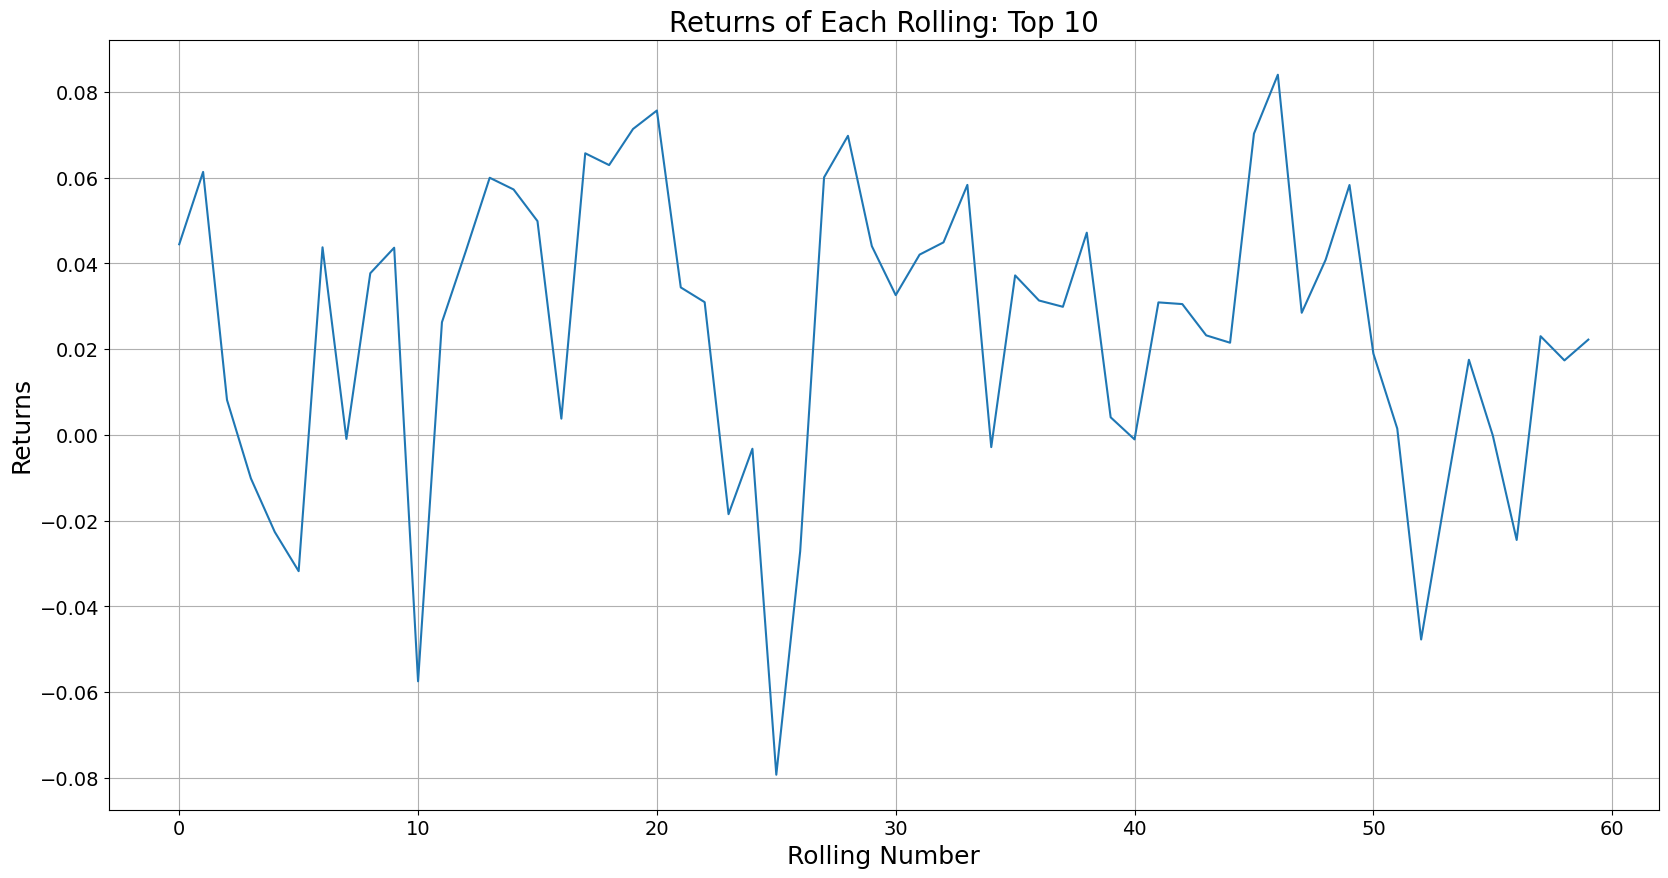

In [70]:
plt.figure(figsize=(20, 10));
plt.plot(total_return);
plt.grid(True);
plt.title("Returns of Each Rolling: Top 10");
plt.xlabel("Rolling Number");
plt.ylabel("Returns")

In [80]:
X = []
for idx in range(1, 61):
    cdf = pd.read_csv(f"data2/corr_{idx}.csv")
    X.append(len(cdf))

In [95]:
bdf = price_df['BTC']
Y = []

formation_start = price_df.index[0]
last_datetime = price_df.index[-1]
trading_end = formation_start + pd.Timedelta(days=540)
cnt = 0
while 1:
    cnt += 1
    formation_end = formation_start +pd.DateOffset(months=12) - pd.Timedelta(days=1)
    trading_start = formation_end + pd.Timedelta(days=1)
    trading_end = trading_start + pd.DateOffset(months=6) - pd.Timedelta(days=1)
    
    if trading_end > last_datetime:
        break
    print(f'#{cnt}:\t {formation_start} ~ {formation_end}\t{trading_start} ~ {trading_end}')
    Y.append(bdf[formation_start:formation_end].mean())
    formation_start += pd.DateOffset(months=1)

#1:	 2018-01-01 00:00:00 ~ 2018-12-31 00:00:00	2019-01-01 00:00:00 ~ 2019-06-30 00:00:00
#2:	 2018-02-01 00:00:00 ~ 2019-01-31 00:00:00	2019-02-01 00:00:00 ~ 2019-07-31 00:00:00
#3:	 2018-03-01 00:00:00 ~ 2019-02-28 00:00:00	2019-03-01 00:00:00 ~ 2019-08-31 00:00:00
#4:	 2018-04-01 00:00:00 ~ 2019-03-31 00:00:00	2019-04-01 00:00:00 ~ 2019-09-30 00:00:00
#5:	 2018-05-01 00:00:00 ~ 2019-04-30 00:00:00	2019-05-01 00:00:00 ~ 2019-10-31 00:00:00
#6:	 2018-06-01 00:00:00 ~ 2019-05-31 00:00:00	2019-06-01 00:00:00 ~ 2019-11-30 00:00:00
#7:	 2018-07-01 00:00:00 ~ 2019-06-30 00:00:00	2019-07-01 00:00:00 ~ 2019-12-31 00:00:00
#8:	 2018-08-01 00:00:00 ~ 2019-07-31 00:00:00	2019-08-01 00:00:00 ~ 2020-01-31 00:00:00
#9:	 2018-09-01 00:00:00 ~ 2019-08-31 00:00:00	2019-09-01 00:00:00 ~ 2020-02-29 00:00:00
#10:	 2018-10-01 00:00:00 ~ 2019-09-30 00:00:00	2019-10-01 00:00:00 ~ 2020-03-31 00:00:00
#11:	 2018-11-01 00:00:00 ~ 2019-10-31 00:00:00	2019-11-01 00:00:00 ~ 2020-04-30 00:00:00
#12:	 2018-12-01 00

Text(0.5, 0, 'Rolling Number')

Text(0, 0.5, 'Pair Number')

Text(0, 0.5, 'Mean Price of BTC')

Text(0.5, 1.0, 'Comparing Pair Number & BTC Price Through Time')

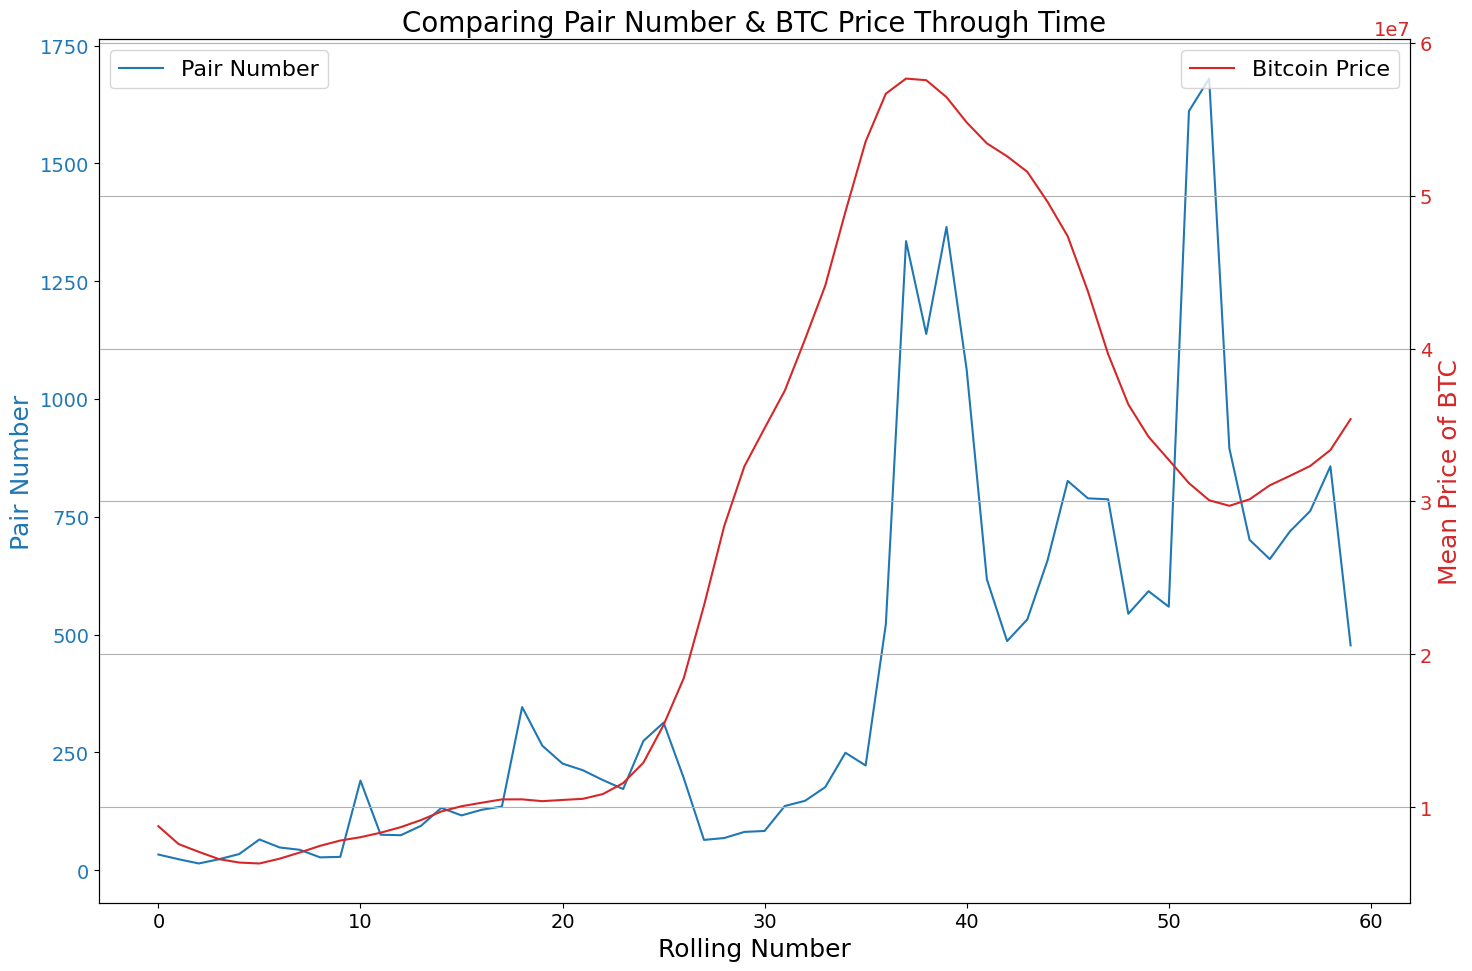

In [102]:
fig, ax1 = plt.subplots(figsize=(15, 10))
color = 'tab:blue'
ax1.set_xlabel('Rolling Number')
ax1.set_ylabel('Pair Number', color=color)
ax1.plot(X, color=color, label='Pair Number')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # 두 번째 y축 생성
color = 'tab:red'
ax2.set_ylabel('Mean Price of BTC', color=color)
ax2.plot(Y, color=color, label='Bitcoin Price')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Comparing Pair Number & BTC Price Through Time')
fig.tight_layout()  # 플롯 간의 간격 조정
plt.grid(True)
plt.show()